In [1]:
#importing necessary libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import mnist dataset

trainset = pd.read_csv("sign_mnist_train.csv")
testset = pd.read_csv("sign_mnist_test.csv")

print("The shape of training set is ",trainset.shape," and the shape of test set is ",testset.shape)

The shape of training set is  (27455, 785)  and the shape of test set is  (7172, 785)


In [3]:
trainset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
testset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [5]:
#storing dependant variable

y = testset['label']

<h3><center>Step 1 - Data Cleaning and Visualization</center></h3>

<AxesSubplot:xlabel='label', ylabel='count'>

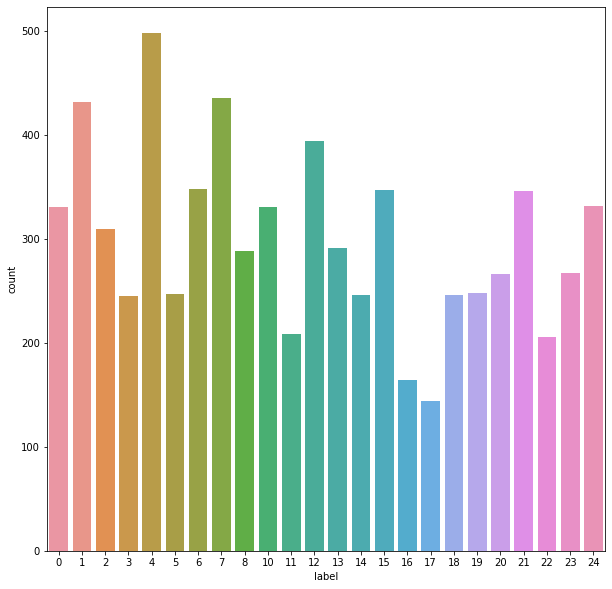

In [6]:
#Check for the distribution of the hand signs, whether the dataset is balanced or not


plt.figure(figsize = (10,10))
sns.countplot(testset['label'])

In [7]:
#There are enough images for all signs
#The numbers represent the following
#Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter
#A-Z (and no cases for 9=J or 25=Z because of gesture motions).

print("Null values in training set :", trainset.isna().sum(),", \n\nNull values in test set are :", testset.isna().sum())

Null values in training set : label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64 , 

Null values in test set are : label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [8]:
#There are no null values in our dataset. Therefore, our dataset is clean
#Now let us move on to the next part

<h3><center>Step 2 - Data Preprocessing</center></h3>


In [9]:
#Splitting into x and y variables for training our model

y_train = trainset['label']
y_test = testset['label']
del trainset['label']
del testset['label']

In [10]:
x_train = trainset.values
x_test = testset.values

In [11]:
#Perform a grayscale normalization to reduce the effect of illumination's differences.
#Moreover the CNN converges faster on [0,..,1] data than on [0,..,255].

x_train = x_train / 255
x_test = x_test / 255

# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [12]:
#Data Augmentation
#In order to avoid overfitting problem, we need to expand artificially our dataset.
#We can make your existing dataset even larger. The idea is to alter the training data with small transformations 
#to reproduce the variations. Approaches that alter the training data in ways that change the array representation
#while keeping the label the same are known as data augmentation techniques. 
#Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters,
#translations, rotations, and much more. By applying just a couple of these transformations to our training data,
#we can easily double or triple the number of training examples and create a very robust model.

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
#The learning rate affects how quickly our model can converge to a local minima i.e arrive at the best accuracy. 
#Thus getting it right from the get go would mean lesser time for us to train the model.
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [14]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [15]:
num_class = len(set(y))
print('No. of classes are ',num_class)

No. of classes are  24


In [16]:
def cnn() : 
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28, 28,1)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten()) 
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(24, activation='softmax'))

    model.compile(
        optimizer = optimizer,
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

cnn_model = cnn()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       5

In [18]:
# Fit the model
from keras.callbacks import ModelCheckpoint
path_model='cnn_v1.h5' 
cnn_history = cnn_model.fit(datagen.flow(x_train,y_train, batch_size=32),
                              epochs = 10, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // 32,
                              callbacks=[learning_rate_reduction,ModelCheckpoint(filepath=path_model)])

Epoch 1/10
857/857 - 27s - loss: 1.1275 - accuracy: 0.6608 - val_loss: 0.1469 - val_accuracy: 0.9506
Epoch 2/10
857/857 - 18s - loss: 0.1828 - accuracy: 0.9413 - val_loss: 0.0115 - val_accuracy: 0.9975
Epoch 3/10
857/857 - 18s - loss: 0.0983 - accuracy: 0.9690 - val_loss: 0.0314 - val_accuracy: 0.9877
Epoch 4/10
857/857 - 18s - loss: 0.0733 - accuracy: 0.9780 - val_loss: 0.0124 - val_accuracy: 0.9969

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
857/857 - 18s - loss: 0.0255 - accuracy: 0.9918 - val_loss: 8.0485e-04 - val_accuracy: 0.9996
Epoch 6/10
857/857 - 18s - loss: 0.0212 - accuracy: 0.9937 - val_loss: 8.1370e-06 - val_accuracy: 1.0000
Epoch 7/10
857/857 - 18s - loss: 0.0179 - accuracy: 0.9942 - val_loss: 8.7686e-05 - val_accuracy: 1.0000
Epoch 8/10
857/857 - 18s - loss: 0.0166 - accuracy: 0.9946 - val_loss: 1.4058e-05 - val_accuracy: 1.0000

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/10
857

In [19]:
#Model Accuracy

print("Model Accuracy is - " , cnn_model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 7ms/step - loss: 9.3763e-07 - accuracy: 1.0000
Model Accuracy is -  100.0 %


In [20]:
def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' +metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

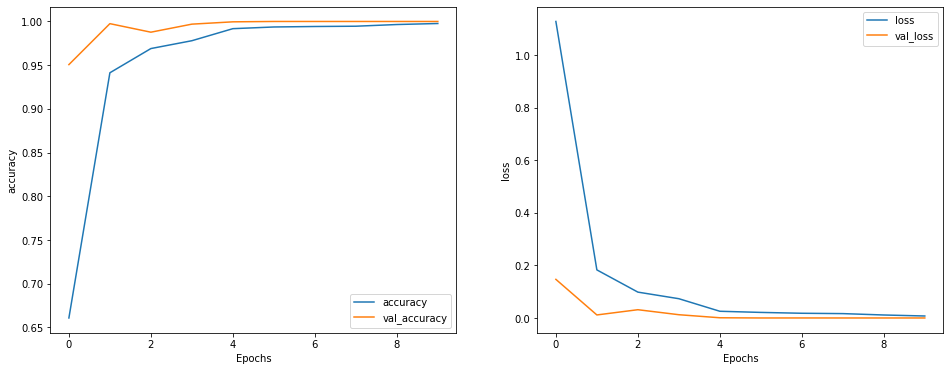

In [21]:
#Plotting our graphs for different models

%matplotlib inline
plt.figure(figsize=(16, 6))


plt.subplot(1,2,1)
plot_graph(cnn_history,'accuracy')
plt.subplot(1,2,2)
plot_graph(cnn_history,'loss')